In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Pyramid
It's a type of multi-scale signal representation, in which a signal or an image is subjected to repeated smoothing and subsampling.

Subsampling is done to reduce amount of data in the spacial domain, that needs to be transmitted, stored or processed. As human visual system is less sensitive for color information than the intensity information (brightness), in a Y-Cr-Cb colorspace, Cr and Cb components (colors) are filtered and sub-sampled at fraction of Y (luma) component.

In short, set of images with different resolutions(different frequency-band images), stacked wtih biggest image at bottom and smallest at top, are called Image Pyramids.
<img src="../resources/pyramid.png">
Two main types of Image Pyramids:
1. Lowpass - Made by smoothing the image with an appropriate smoothing filter and then subsampling the smoothed image, usually by a factor of 2 along each coordinate direction.
2. Bandpass - Made by forming the difference between images at adjacent levels in the pyramid and performing some kind of image interpolation between adjacent levels of resolution, to enable computation of pixelwise differences.


- Guassian Pyramid - It's a lowpass pyramid. As we move from lower level (high resolution) to higher level (low resolution), images are weighted down using a Gaussian Blur and scaled down. Each pixel contains a local average that corresponds to a pixel neighborhood on a lower level of the pyramid. At each level, image size is reduced by a factor of 0.5. (It's better to perform convolution with one signle image being resized again and again rather than performing convolutions of image wtih various kernels to get different level outputs)
- Laplacian Pyramid - It's a bandpass pyramid. Each layer is made from difference between that level in Gaussian Pyramid and expanded version of it's upper level in Gaussian Pyramid.


Uses of Pyramids
1. Laplacian Pyramid prodcues edge images.
2. Laplacian Pyramid is used in image compression.
3. Image blending.

Pyramids are great for image representation as they have both spatial-frequency domain and are easy to compute.

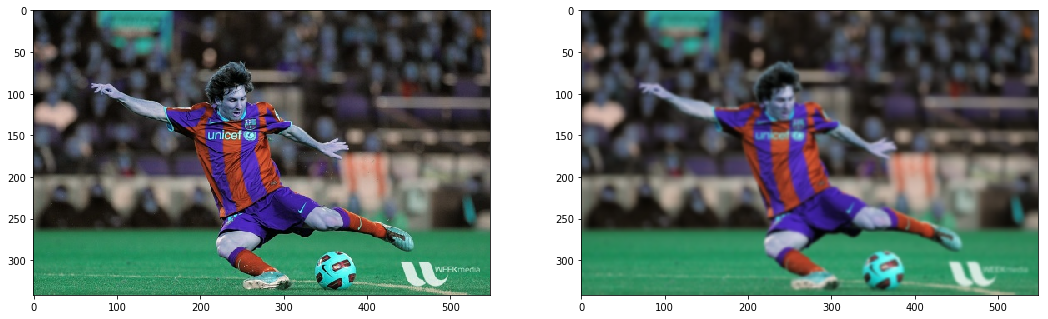

In [6]:
image = cv2.imread("../resources/messi.jpg")

# Gaussian Pyramid
lower_reso1 = cv2.pyrDown(image)
original = cv2.pyrUp(lower_reso1)  # will be blurred due to image smoothing (some information is lost)

fig = plt.figure()
fig.set_size_inches(18, 10)
fig.add_subplot(1, 2, 1)
plt.imshow(image)
fig.add_subplot(1, 2, 2)
plt.imshow(original)
plt.show()

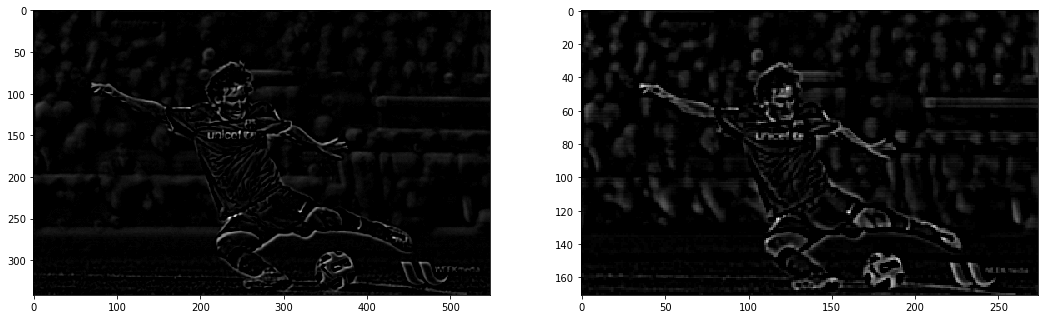

In [68]:
# Laplacian Pyramid
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
down1 = cv2.pyrDown(gray)
down2 = cv2.pyrDown(down1)

down2 = cv2.resize(down2, (down1.shape[1], down1.shape[0]), interpolation=cv2.INTER_LINEAR)
laplacian2 = cv2.subtract(down1, down2)

down1 = cv2.resize(down1, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_LINEAR)
laplacian1 = cv2.subtract(gray, down1)

fig = plt.figure()
fig.set_size_inches(18, 10)

fig.add_subplot(1, 2, 1)
plt.imshow(laplacian1, cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(laplacian2, cmap='gray')

plt.show()

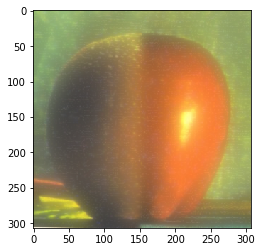

In [76]:
# Image Blending
orange = cv2.imread("../resources/orange.jpg")
apple = cv2.imread("../resources/apple.jpg")

orange_copy = orange.copy()
apple_copy = apple.copy()
gauss_orange = [orange_copy]
gauss_apple = [apple_copy]
for i in range(5):
    orange_copy = cv2.pyrDown(orange_copy)
    gauss_orange.append(orange_copy)
    
    apple_copy = cv2.pyrDown(apple_copy)
    gauss_apple.append(apple_copy)

laplacian_orange = [gauss_orange[4]]
laplacian_apple = [gauss_apple[4]]
for i in range(4, 0, -1):
    higher_orange = cv2.pyrUp(gauss_orange[i], dstsize=(gauss_orange[i-1].shape[1], gauss_orange[i-1].shape[0]))
    diff_orange = cv2.subtract(gauss_orange[i-1], higher_orange)
    laplacian_orange.append(diff_orange)
    
    higher_apple = cv2.pyrUp(gauss_apple[i], dstsize=(gauss_apple[i-1].shape[1], gauss_apple[i-1].shape[0]))
    diff_apple = cv2.subtract(gauss_apple[i-1], higher_apple)
    laplacian_apple.append(diff_apple)

blends = []
for lap_orange, lap_apple in zip(laplacian_orange, laplacian_apple):
    rows, cols, depth = lap_orange.shape
    blend = np.hstack((lap_orange[:, 0:cols/2], lap_apple[:, cols/2:]))
    blends.append(blend)

reconstructed = blends[0]
for i in range(1, 5):
    reconstructed = cv2.pyrUp(reconstructed, dstsize=(blends[i].shape[1], blends[i].shape[0]))
    reconstructed = cv2.add(reconstructed, blends[i])

plt.imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
plt.show()

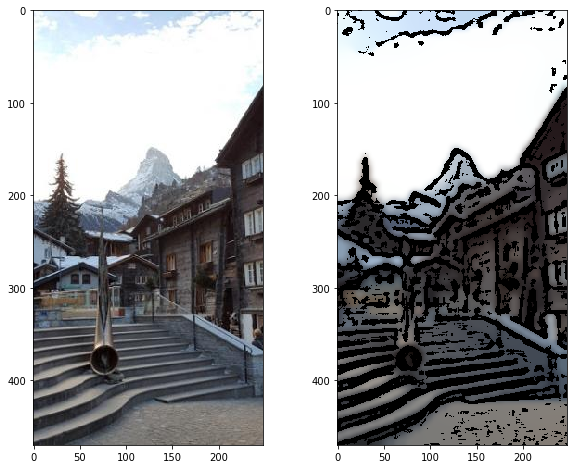

In [89]:
# Cartoon Effect
# better to downsample first, reduce color information and then upsample
# down-sample the image
image = cv2.imread("../resources/scene.jpg")
color = image.copy()
for i in range(2):
    color = cv2.pyrDown(color)

# better to apply small filter repeatedly than apply a slow big filter
for i in range(7):
    color = cv2.bilateralFilter(color, 9, 9, 7)

# up-sample the image
for i in range(2):
    color = cv2.pyrUp(color)

# reduce noise
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(gray, 7)

edges = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 2)
edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

color = cv2.resize(color, (edges.shape[1], edges.shape[0]))
cartoon = cv2.bitwise_and(color, edges)

fig = plt.figure()
fig.set_size_inches(10, 8)

fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cartoon, cv2.COLOR_BGR2RGB))

plt.show()